this use heatmap instead of imshow to generate oncoprint should be adopted from now on.

In [1]:
import pandas as pd
import numpy as np
import string as s
import seaborn as sns
import math
# import tables
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style, colors
from itertools import groupby
import matplotlib.patches as patches
from matplotlib import gridspec
import scipy.stats as stats
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, fclusterdata, leaves_list
from scipy.spatial.distance import pdist
from scipy.ndimage.interpolation import shift
# matplotlib.style.use('ggplot')
# %matplotlib inline
matplotlib.rcParams['figure.figsize'] = (8, 6)
# matplotlib.rcParams['figure.facecolor'] = 'white'
import mpl_toolkits.mplot3d.axes3d as p3
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets.samples_generator import make_swiss_roll
matplotlib.style.use('ggplot')
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [56]:
# choose color from here
# http://colorbrewer2.org/#type=diverging&scheme=RdYlBu&n=4

# 52 samples in total, 20 hiv+, 18 hiv-, 7 hiv+ controls, 7 hiv- controls

https://www.bcgsc.ca/jira/browse/DA-167

https://www.bcgsc.ca/jira/browse/PIPE-1102

118 patients are here:
/projects/trans_scratch/validations/workspace/szong/Cervical/mutsig2cv/118_patients.txt, we loose two hypermutated cases when using 118 patients as discovery cohort.

In [2]:
wkdir = '/projects/da_workspace/DA-167_Cervical_epi_clustering/'
mark='H3K27ac'

# get all narrow peak and broad peak files

In [3]:
%%bash -s $wkdir
cd $1
ls -1 /projects/chipseq/macs/A*/75nt/hg19a/bwa-mem-0.7.6a-sb/MACS_2.1.1.20160309/*.broadPeak>bp.tmp
ls -1 /projects/chipseq/macs/A*/75nt/hg19a/bwa-mem-0.7.6a-sb/MACS_2.1.1.20160309/*.narrowPeak>np.tmp
cat bp.tmp np.tmp >a.tmp
cat a.tmp |awk -F "/" '{print $5"\t"$0}'|awk -F "_" '{print $3"\t"$0}'>d.tmp

while read a b c;do grep $b 54_chipseq_samples_library_ids.csv|cut -f 1|\
awk -v lib=$b -v path=$c -v mark=$a -F "-01" '{print $1"\t"lib"\t"mark"\t"path}' ;done \
< d.tmp |sort -k1 -k2 > cellmarkfiletable.txt.full.path.new
rm a.tmp  d.tmp 
head -2 cellmarkfiletable.txt.full.path.new

ls: cannot access /projects/chipseq/macs/A*/75nt/hg19a/bwa-mem-0.7.6a-sb/MACS_2.1.1.20160309/*.broadPeak: No such file or directory
ls: cannot access /projects/chipseq/macs/A*/75nt/hg19a/bwa-mem-0.7.6a-sb/MACS_2.1.1.20160309/*.narrowPeak: No such file or directory


In [144]:
# missing files for H3K4me3:
#     HTMCP-03-06-02195-01B	positive	non mutated A94364
#     HTMCP-03-06-02256-01A	negative	mutated	A84814



# intersect with promoters

In [436]:
%%bash
#sort peak files and intersect with merged/split peak regions, required 50% overlap
promoters='/projects/trans_scratch/validations/workspace/szong/Cervical/chipseq/hg19v69_genes.TSS_2000.pc.bed.cleaned'
bedtools=/home/rcorbett/aligners/bedtools/BEDTools-Version-2.15.0/bin/bedtools
wkdir='/projects/da_workspace/DA-167_Cervical_epi_clustering/'
markfile='cellmarkfiletable.txt.full.path.new'
mark='H3K4me3'
cd $wkdir
mkdir $mark"_promoter2"
grep $mark $wkdir$markfile > $mark.peak.files.txt
while read a b c d;do cat $d|grep -v "^GL"|grep -v "^MT"|grep -v "^chr"|sed 's/^X/23/g'|\
sed 's/^Y/24/g'|sort -k1n -k2n -k3n >$a.$c.sorted;done < $mark.peak.files.txt

# cd $wkdir
# while read i;do grep $i cellmarkfiletable.txt.full.path>$mark/$i.peak.files.txt;done < marks.txt

# do we need to filter based on q value?
# awk '$3-$2>100' $mark"_coor_with_peaks_merged_1kb_split.txt">  $mark"_coor_with_peaks_merged_1kb_split.rm.txt"

# intersect with putative promoters. there are times that one gene has multiple peaks, should keep the tallest peak?
for f in HTMCP*.$mark.sorted; \
do $bedtools intersect -a $promoters -b $f -f 0.1 -wa -wb>$mark"_promoter2"/$f.intersected;\
done

# remove intermediate files
rm HTMCP*.$mark.sorted

mkdir: cannot create directory `H3K4me3_promoter2': File exists


# merge all peak fold changes into a dataframe

In [437]:
f3 = '/projects/da_workspace/DA-167_Cervical_epi_clustering/{0}_promoter2/{0}_promoter_intersected_files.txt'.format(mark)
df3 = pd.read_csv(f3, header=None)
df3.columns = ['files']
df3.head(2)
df3.shape

,files
0,/projects/da_workspace/DA-167_Cervical_epi_clu...
1,/projects/da_workspace/DA-167_Cervical_epi_clu...


(52, 1)

In [438]:
subdir = f'{wkdir}{mark}_promoter2'
dfmg = pd.DataFrame()
for ix, row in df3.iterrows():
    patient = row.files.split('/')[-1].split('.')[0]
    f = row.files
    dftmp = pd.read_csv(f, sep='\t', header=None)
    dftmp.columns = ['chr_pro', 'chr_pro_start', 'chr_pro_end', 'gene', 
                     'chr', 'start', 'end', 'peak_id', 'qvalue_int_score', 
                     'unknown', 'fold_change', '-log10pvalue', '-log10qvalue', 
                     'summit_position' ]
    dftmp = dftmp[['chr_pro', 'chr_pro_start', 'chr_pro_end', 'fold_change']]
    dftmp = dftmp.sort_values(['chr_pro', 'chr_pro_start', 'chr_pro_end','fold_change'])
    dftmp.set_index(['chr_pro', 'chr_pro_start', 'chr_pro_end'], inplace=True)
#     deal with one gene has multiple peaks in promoter region
    dftmp = dftmp[~dftmp.index.duplicated(keep='last')]
    dftmp.columns = [patient]
    if dfmg.empty:
        dfmg = dftmp
    else:
        dfmg = pd.merge(dfmg, dftmp, left_index=True, right_index=True, how='outer')


In [439]:
dfmg.reset_index(inplace=True)

In [440]:
dfmg.head(2)

,chr_pro,chr_pro_start,chr_pro_end,HTMCP-03-06-02001,HTMCP-03-06-02002,HTMCP-03-06-02006,HTMCP-03-06-02007,HTMCP-03-06-02012,HTMCP-03-06-02020,HTMCP-03-06-02026,...,HTMCP-03-06-02230,HTMCP-03-06-02235,HTMCP-03-06-02260,HTMCP-03-06-02261,HTMCP-03-06-02266,HTMCP-03-06-02267,HTMCP-03-06-02268,HTMCP-03-06-02320,HTMCP-03-06-02330,HTMCP-03-06-02332
0,1,34081,38080,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.64580,NaN,NaN,NaN,4.45901,NaN,NaN,NaN,NaN,NaN
1,1,858261,862260,4.73582,8.54521,8.52459,17.15151,9.51227,12.2435,10.53425,...,11.10221,14.14449,10.36509,7.06183,11.70068,7.76152,9.2453,10.30638,9.6932,13.49828


In [441]:
dfmg.shape

(17228, 55)

# clustering and plot starts herer

# hierarchical clustering

In [3]:
# my_colors = [ "purple", "lightgray", "#E69F00","#009E73","#56B4E9","#377EB8","#E41A1C","#F0E442",'black',"#D55E00","#CC79A7"]

In [21]:
def get_legend_categories(df_covariates):
    a = []
    covariate_dict = {}
    for ix, row in pd.DataFrame(df_covariates.apply(lambda x: sorted(x.unique().tolist()), axis=1)).iterrows():
    #     print(ix, row[0])
        item = row[0]
        if item not in a:
            a.append(item)
            covariate_dict[ix] = item
    return covariate_dict

In [22]:
def add_numeric_covariate(df_covariates):
    df_covariates = df_covariates[col_den_labels].fillna(0.0)
    nrows = df_covariates.shape[0]
    fig = plt.figure(figsize=(32,.5*nrows), facecolor='white')
    gs = gridspec.GridSpec(nrows, 2,                            
                           width_ratios=[1,18], 
                           height_ratios=[1]*nrows,
                           wspace=0.0, # horizontal space
                           hspace=0.0  # vertical space
                          )
    grid_num = 0
    for ix, row in df_covariates.iterrows():
        dfa = pd.DataFrame(index=[ix], columns=df_covariates.columns)
        dfa.loc[ix,:] = df_covariates.loc[ix,].astype(float)
        dfa = dfa.astype(float)
        # add cbar ax
        gs0 = gs[grid_num]
        ax0 =  plt.subplot(gs0, frameon=False)   
        _ = ax0.get_xaxis().set_ticks([])
        _ = ax0.get_yaxis().set_ticks([])
        _ = ax0.set_title('')


        # add covariate track legend
        gs1 = gs[grid_num+1]
        _ = ax1 = plt.subplot(gs1, facecolor='white')
        _ = ax1.set_title("")  
        _ = sns.heatmap(dfa, 
                        ax=ax1, 
                        cmap = sns.light_palette('red', as_cmap=True),
                        linewidths=.05,                    
                        xticklabels=False,
                        yticklabels=False,
                        cbar=True,
                        cbar_ax=ax0)
        _ = ax1.tick_params(axis='y', which='major', labelsize=5)
        _ = ax1.set_yticklabels(ax1.yaxis.get_majorticklabels(), rotation=0)
        _ = ax1.yaxis.tick_right()

        grid_num+=2
    plt.show()
    return dfa


In [23]:
def order_df(df, row_labels, col_labels):
    df = df[col_labels].reindex(row_labels)
    return df

In [24]:
def get_category_cmap(color_dict, categories):
    """
    figure out color for categorical variables
    color length must match category's, otherwise it will sample all available colors or reuse colors
    """
    map_dict = {k:v for v, k in  enumerate(categories)} 
    clrs = [color_dict[k] for k in categories]
    cmap = colors.ListedColormap(clrs)
    return (map_dict, cmap)

In [25]:
def plot_categorical_covariate(df, gs): 
    # df ordered by row and cols, col order matches dendrogram
    nrows = df.shape[0]
    gssubs = gridspec.GridSpecFromSubplotSpec(nrows, 1,  
                                    height_ratios=[1]*nrows,
                                    subplot_spec=gs)
    grid_num = 0
    for ix, row in df.iterrows():
        categories = sorted(row.unique())
        map_dict, cmap = get_category_cmap(color_dict, categories)
        df_mapped = pd.DataFrame(index=[ix], columns=df.columns)
        df_mapped.loc[ix,:] = df.loc[ix,].map(map_dict)#.astype(float)

        # add covariate track legend
        gs11 = gssubs[grid_num]
        ax11 = plt.subplot(gs11, facecolor='white')
        _ = ax11.set_title("")  
        _ = sns.heatmap(df_mapped, 
                        ax=ax11, 
                        cmap=cmap,
                        linewidths=.05,                    
                        xticklabels=False,
                        yticklabels=False,
                        cbar=False)#,
#                         cbar_ax=ax00)
        _ = ax11.tick_params(axis='y', which='major', labelsize=5)
        _ = ax11.set_yticklabels(ax11.yaxis.get_majorticklabels(), rotation=0)
        _ = ax11.yaxis.tick_right()
        _ = ax11.set_title("")
        _ = ax11.set_xlabel('')
        _ = ax11.set_ylabel(ix, rotation=0, fontsize=10)
        ax11.get_yaxis().set_label_coords(-0.15,0.5)
#         ax11.yaxis.set_label_position("right")
        grid_num+=1

In [26]:
def plot_categorical_legend(gs):
    ax =  plt.subplot(gs, frameon=True,facecolor='white')
    num_legends = len(covariate_dict)
    column = 0
    for covariate in covariate_dict:
        groups = covariate_dict[covariate]
        add_patches(covariate, ax, groups, column, color_dict, num_legends)
        column+=1

In [37]:
#use this to make clustered heatmap and use add_covariate to make separate tracksS
def plot_cluster_heatmap(dfm, df_covariates):  
    fig = plt.figure(figsize=(16, 20), facecolor='white')
    gs = gridspec.GridSpec(3, 2, width_ratios=[1,15], height_ratios=[10, 2, 3], 
                           wspace=0.0, # horizontal space
                           hspace=0.3)  # vertical space
      
    # plot sample (patient) dendrogram
    ax3 = plt.subplot(gs[3], facecolor='white')
    ax3.set_title("")
#     col_den_labels = plot_dengrogram(dfm, ax3)
    col_den_labels = plot_dengrogram_jeremy(dfm, ax3)
    
    
    # plot categorical covariate heatmap
    plot_categorical_covariate(df_covariates, gs[1])


    # plot categorical lenged
    plot_categorical_legend(gs[5])
    
#     assert row_den_labels == df_hm.index.tolist()
#     assert col_den_labels == df_hm.columns.tolist()

    of = '{0}/{1}_heatmap.png'.format(wkdir, mark)
    %time plt.savefig(of, bbox_inches='tight',dpi=300)
    plt.show()
    plt.close()
    return col_den_labels

In [28]:
def add_patches(covariate, ax, features, column, color_dict, num_legends):
    k = 0
    _ = ax.text(0.0+column*(1/(num_legends + .2)), .9, 
                 covariate, 
                 ha='left', 
                 va='center', 
                 fontsize=12)
#     print(sorted(features))
    for feature in sorted(features):
#         print(feature)
        types = len(features)
        clr = color_dict[feature]
#         clr = clrmap_dict[feature]
        rect = patches.Rectangle((0+column*(1/(num_legends + .2)), .8-k*0.15), .02, .05, 
                             linewidth=0.001,
                             edgecolor=clr,
                             facecolor=clr)

        _ = ax.text(0.05+column*(1/(num_legends + .2)), .8-k*0.15+.03, 
                     feature, 
                     ha='left', 
                     va='center', 
                     fontsize=9)
        _ = ax.add_patch(rect)
        k+=1
    _ = ax.get_xaxis().set_ticks([])
    _ = ax.get_yaxis().set_ticks([])
    _ = ax.set_title('')

In [3]:
def plot_dengrogram(df, ax):
    """
    df: rows are features, intervals marked or not, columns are samples, eg. patient
    add column dendrogram
    pdist(Y,'jaccard') returns jaccard distance, which is 1-jaccard similarity value, pairwise distance, so order in each vector matters, 
    but paired u[i], v[i] change order does not matter. important to note, it ignores pairs with both values are 0.
    pdist([[1, 2, 2], [2,2,1]],'jaccard') = 0.666 not 0
    pdist([0,1,1], [0,0,1]) = 0.5
    """
    matrix = df.T.values
#     dist='jaccard' # this is jaccard distance 1-jaccard value
#     link='complete'    
    dist = 'correlation'
    link = 'ward'
    Z = linkage(pdist(matrix, dist), link)
     col_den = dendrogram(Z, leaf_rotation=90.,
                         labels = df.columns,
                         leaf_font_size=12,
                         show_contracted=True, 
                         ax=ax)
#                          no_labels=True)
    col_den_labels = col_den['ivl']
    return col_den_labels

In [29]:
wkdir = '/projects/da_workspace/DA-167_Cervical_epi_clustering/'
mark='H3K4me3'

In [30]:
f = '/projects/trans_scratch/validations/workspace/szong/Cervical/color_maps.txt'
df_clrs = pd.read_csv(f, sep='\t', header=None)
color_dict = pd.Series(df_clrs[1].values,index=df_clrs[0]).to_dict()
df_clrs.head(2)
list(color_dict.items())[0]

,0,1
0,HPV16,#7F3B08
1,HPV31,#B35806


('HPV16', '#7F3B08')

In [5]:
feather_file = f'{wkdir}{mark}_promoter2/fold_change_matrix.feather'
# dfmg.to_feather(feather_file)
dfmg = pd.read_feather(feather_file)
dfmg.set_index(['chr_pro', 'chr_pro_start', 'chr_pro_end'], inplace=True)
dfmg.fillna(0, inplace=True) # 0 means no signal change relative to controls
# dfmg['std'] = dfmg.apply(lambda x: np.std(x), axis=1)
# dfmg = dfmg[dfmg['std']>dfmg['std'].describe()['75%']].drop('std', axis=1)
dfmg.head()

HTMCP-03-06-02001  HTMCP-03-06-02002  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                  0.00000            0.00000   
        365641        369640                 0.00000            0.00000   
        858261        862260                 4.73582            8.54521   
        892689        896688                 7.80314           15.80895   
        893968        897967                 7.80314           15.80895   

                                   HTMCP-03-06-02006  HTMCP-03-06-02007  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                  0.00000            0.00000   
        365641        369640                 0.00000            0.00000   
        858261        862260                 8.52459           17.15151   
        892689        896688                16.17969           35.44883   
        893968        897967                16.17969           35.44883   

                                   HTMCP-03-06-02012  HTMCP-03-06-02020  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                  0.00000            0.00000   
        365641        369640                 0.00000            0.00000   
        858261        862260                 9.51227           12.24350   
        892689        896688                20.46108           19.08545   
        893968        897967                20.46108           19.08545   

                                   HTMCP-03-06-02026  HTMCP-03-06-02036  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                  4.71408            2.90228   
        365641        369640                 0.00000            0.00000   
        858261        862260                10.53425           11.25621   
        892689        896688                15.28026           18.89524   
        893968        897967                15.28026           18.89524   

                                   HTMCP-03-06-02037  HTMCP-03-06-02040  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                  8.37466            7.42527   
        365641        369640                 0.00000            3.10827   
        858261        862260                 7.53719           10.10188   
        892689        896688                13.88429           16.31843   
        893968        897967                13.88429           16.31843   

                                         ...          HTMCP-03-06-02230  \
chr_pro chr_pro_start chr_pro_end        ...                              
1       34081         38080              ...                    3.64580   
        365641        369640             ...                    0.00000   
        858261        862260             ...                   11.10221   
        892689        896688             ...                   18.98120   
        893968        897967             ...                   18.98120   

                                   HTMCP-03-06-02235  HTMCP-03-06-02260  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                  0.00000            0.00000   
        365641        369640                 0.00000            0.00000   
        858261        862260                14.14449           10.36509   
        892689        896688                25.76318           22.21091   
        893968        897967                25.76318           22.21091   

                                   HTMCP-03-06-02261  HTMCP-03-06-02266  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                  0.00000            4.45901   
        365641        369640                 0.00000            0.00000   
        858261        862260                 7.06183 

In [11]:
pd.Series(dfmg.values.ravel()).describe()

count    937144.000000
mean         16.251176
std          11.330879
min           0.000000
25%           6.690160
50%          17.067370
75%          24.112420
max          67.126320
dtype: float64

In [47]:
?hc.distance

In [20]:
dfmg.shape
dfmg.head(2)
corr.shape
corr

(18022, 52)

HTMCP-03-06-02001  HTMCP-03-06-02002  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                      0.0                0.0   
        365641        369640                     0.0                0.0   

                                   HTMCP-03-06-02006  HTMCP-03-06-02007  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                      0.0                0.0   
        365641        369640                     0.0                0.0   

                                   HTMCP-03-06-02012  HTMCP-03-06-02020  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                      0.0                0.0   
        365641        369640                     0.0                0.0   

                                   HTMCP-03-06-02026  HTMCP-03-06-02036  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                  4.71408            2.90228   
        365641        369640                 0.00000            0.00000   

                                   HTMCP-03-06-02037  HTMCP-03-06-02040  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                  8.37466            7.42527   
        365641        369640                 0.00000            3.10827   

                                         ...          HTMCP-03-06-02230  \
chr_pro chr_pro_start chr_pro_end        ...                              
1       34081         38080              ...                     3.6458   
        365641        369640             ...                     0.0000   

                                   HTMCP-03-06-02235  HTMCP-03-06-02260  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                      0.0                0.0   
        365641        369640                     0.0                0.0   

                                   HTMCP-03-06-02261  HTMCP-03-06-02266  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                      0.0            4.45901   
        365641        369640                     0.0            0.00000   

                                   HTMCP-03-06-02267  HTMCP-03-06-02268  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                      0.0                0.0   
        365641        369640                     0.0                0.0   

                                   HTMCP-03-06-02320  HTMCP-03-06-02330  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                      0.0            3.20928   
        365641        369640                     0.0            0.00000   

                                   HTMCP-03-06-02332  
chr_pro chr_pro_start chr_pro_end                     
1       34081         38080                   2.5391  
        365641        369640                  0.0000  

[2 rows x 52 columns]

(52, 52)

array([[1.    , 0.834 , 0.85  , ..., 0.8025, 0.8128, 0.8182],
       [0.834 , 1.    , 0.8742, ..., 0.8638, 0.851 , 0.8672],
       [0.85  , 0.8742, 1.    , ..., 0.8536, 0.8507, 0.8433],
       ...,
       [0.8025, 0.8638, 0.8536, ..., 1.    , 0.8535, 0.8349],
       [0.8128, 0.851 , 0.8507, ..., 0.8535, 1.    , 0.8193],
       [0.8182, 0.8672, 0.8433, ..., 0.8349, 0.8193, 1.    ]])

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
count,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,...,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000
mean,0.823154,0.854979,0.856369,0.836129,0.857521,0.853402,0.840483,0.840442,0.811213,0.815488,...,0.781679,0.786469,0.862704,0.800842,0.838096,0.854202,0.845375,0.837194,0.834200,0.830335
std,0.034660,0.035866,0.035559,0.032580,0.035242,0.036826,0.032803,0.030585,0.033701,0.034038,...,0.034172,0.035577,0.038493,0.034711,0.032256,0.039581,0.043441,0.040879,0.035526,0.034921
min,0.754800,0.771000,0.780000,0.757900,0.783700,0.782500,0.775900,0.781500,0.745800,0.761000,...,0.732600,0.731800,0.778300,0.736700,0.775100,0.771400,0.759200,0.743100,0.768500,0.755800
25%,0.807375,0.834750,0.841975,0.823400,0.842350,0.833000,0.829950,0.825450,0.798075,0.799725,...,0.768950,0.772100,0.840325,0.786750,0.823275,0.835075,0.821625,0.813500,0.814225,0.810900
50%,0.819800,0.860000,0.861500,0.838650,0.862000,0.855450,0.847500,0.840650,0.814300,0.816350,...,0.782500,0.785050,0.869650,0.801550,0.840400,0.858700,0.848100,0.845550,0.840100,0.832800
75%,0.840275,0.876025,0.874825,0.848875,0.874300,0.875625,0.853700,0.851125,0.821600,0.828875,...,0.787700,0.795000,0.883600,0.812425,0.850825,0.878200,0.872450,0.857550,0.850775,0.846500
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


count    1326.000000
mean        0.169445
std         0.034806
min         0.085400
25%         0.143825
50%         0.165100
75%         0.195950
max         0.277000
dtype: float64

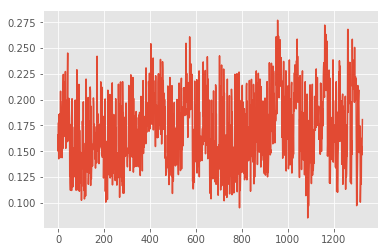

In [38]:
plt.plot(corr_condensed)
pd.DataFrame(corr).describe()
pd.Series(corr_condensed).describe()

In [446]:
dfmg.shape

(17228, 52)

In [456]:
dfmg = dfmg > 0
dfmg.head(2)

HTMCP-03-06-02001  HTMCP-03-06-02002  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                    False              False   
        858261        862260                    True               True   

                                   HTMCP-03-06-02006  HTMCP-03-06-02007  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                    False              False   
        858261        862260                    True               True   

                                   HTMCP-03-06-02012  HTMCP-03-06-02020  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                    False              False   
        858261        862260                    True               True   

                                   HTMCP-03-06-02026  HTMCP-03-06-02036  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                    False               True   
        858261        862260                    True               True   

                                   HTMCP-03-06-02037  HTMCP-03-06-02040  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                     True              False   
        858261        862260                    True               True   

                                         ...          HTMCP-03-06-02230  \
chr_pro chr_pro_start chr_pro_end        ...                              
1       34081         38080              ...                       True   
        858261        862260             ...                       True   

                                   HTMCP-03-06-02235  HTMCP-03-06-02260  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                    False              False   
        858261        862260                    True               True   

                                   HTMCP-03-06-02261  HTMCP-03-06-02266  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                    False               True   
        858261        862260                    True               True   

                                   HTMCP-03-06-02267  HTMCP-03-06-02268  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                    False              False   
        858261        862260                    True               True   

                                   HTMCP-03-06-02320  HTMCP-03-06-02330  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                    False              False   
        858261        862260                    True               True   

                                   HTMCP-03-06-02332  
chr_pro chr_pro_start chr_pro_end                     
1       34081         38080                    False  
        858261        862260                    True  

[2 rows x 52 columns]

In [57]:
dfmg.head(2)

HTMCP-03-06-02001  HTMCP-03-06-02002  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                      0.0                0.0   
        365641        369640                     0.0                0.0   

                                   HTMCP-03-06-02006  HTMCP-03-06-02007  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                      0.0                0.0   
        365641        369640                     0.0                0.0   

                                   HTMCP-03-06-02012  HTMCP-03-06-02020  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                      0.0                0.0   
        365641        369640                     0.0                0.0   

                                   HTMCP-03-06-02026  HTMCP-03-06-02036  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                  4.71408            2.90228   
        365641        369640                 0.00000            0.00000   

                                   HTMCP-03-06-02037  HTMCP-03-06-02040  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                  8.37466            7.42527   
        365641        369640                 0.00000            3.10827   

                                         ...          HTMCP-03-06-02230  \
chr_pro chr_pro_start chr_pro_end        ...                              
1       34081         38080              ...                     3.6458   
        365641        369640             ...                     0.0000   

                                   HTMCP-03-06-02235  HTMCP-03-06-02260  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                      0.0                0.0   
        365641        369640                     0.0                0.0   

                                   HTMCP-03-06-02261  HTMCP-03-06-02266  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                      0.0            4.45901   
        365641        369640                     0.0            0.00000   

                                   HTMCP-03-06-02267  HTMCP-03-06-02268  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                      0.0                0.0   
        365641        369640                     0.0                0.0   

                                   HTMCP-03-06-02320  HTMCP-03-06-02330  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                      0.0            3.20928   
        365641        369640                     0.0            0.00000   

                                   HTMCP-03-06-02332  
chr_pro chr_pro_start chr_pro_end                     
1       34081         38080                   2.5391  
        365641        369640                  0.0000  

[2 rows x 52 columns]

In [16]:
?pdist

In [12]:
pdist(dfmg.T.values, 'correlation')

array([0.14181977, 0.14227149, 0.16572946, ..., 0.11119228, 0.11886395,
       0.14015645])

In [15]:
corr = np.round(scipy.stats.spearmanr(dfmg).correlation, 4)
corr_condensed = hc.distance.pdist(1-corr)
corr_condensed

array([0.36437649, 0.34248673, 0.29728742, ..., 0.22398632, 0.26541822,
       0.27880151])

In [ ]:
# detour to test a script from Jeremy Howard's ml course, hierarchical cluster
from scipy.cluster import hierarchy as hc
import scipy

In [39]:
def plot_dengrogram_jeremy(dfmg, ax):
    
    corr = np.round(scipy.stats.spearmanr(dfmg).correlation, 4)
    corr_condensed = hc.distance.pdist(1-corr)
    z = hc.linkage(corr_condensed, method='ward')
#     fig = plt.figure(figsize=(16,4))
    sample_labels = hc.dendrogram(z, labels=dfmg.columns, orientation='top', leaf_font_size=12, ax=ax)
#     plt.show()
    return sample_labels

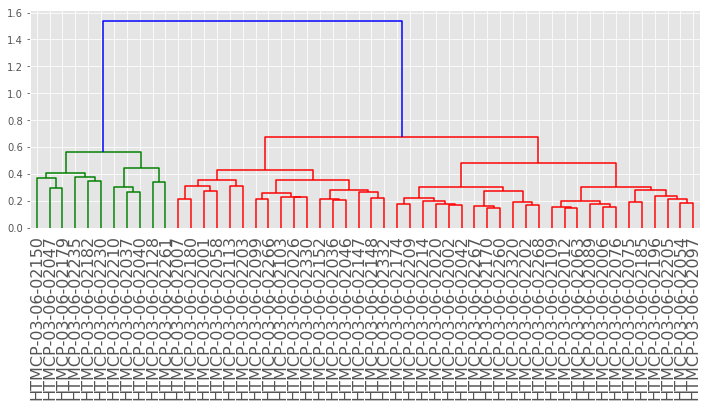

In [36]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)
plot_dengrogram_jeremy(dfmg, ax)

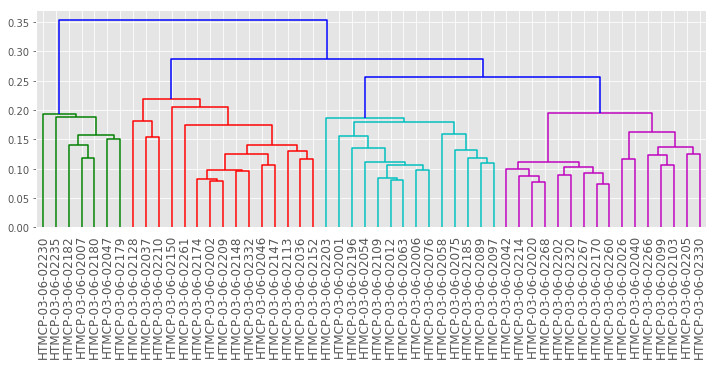

In [6]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)
sample_labels = plot_dengrogram(dfmg, ax)

In [18]:
f = f'{wkdir}clinic_covariate_20181009.csv.added'
df_covariates = pd.read_csv(f, index_col='patient', sep='\t')
# df_covariates.strelka_mutations = df_covariates.strelka_mutations.astype('int64')
df_covariates = df_covariates.T.fillna('unknown')
df_covariates.head(2)

patient,HTMCP-03-06-02001,HTMCP-03-06-02002,HTMCP-03-06-02006,HTMCP-03-06-02007,HTMCP-03-06-02012,HTMCP-03-06-02020,HTMCP-03-06-02026,HTMCP-03-06-02036,HTMCP-03-06-02037,HTMCP-03-06-02040,...,HTMCP-03-06-02235,HTMCP-03-06-02256,HTMCP-03-06-02260,HTMCP-03-06-02261,HTMCP-03-06-02266,HTMCP-03-06-02267,HTMCP-03-06-02268,HTMCP-03-06-02320,HTMCP-03-06-02330,HTMCP-03-06-02332
epi_mutated,Mutated,Mutated,Mutated,Mutated,Mutated,Mutated,Mutated,Wild Type,Wild Type,Mutated,...,Wild Type,Mutated,Mutated,Wild Type,Mutated,Wild Type,Mutated,Mutated,Mutated,Mutated
Remodeller,Wild Type,Wild Type,Mutated,Mutated,Mutated,Mutated,Mutated,Wild Type,Wild Type,Mutated,...,Wild Type,Wild Type,Mutated,Wild Type,Mutated,Wild Type,Wild Type,Wild Type,Wild Type,Mutated


patient
HTMCP-03-06-02001    bool
HTMCP-03-06-02002    bool
dtype: object

,Remodeller,Reader,Writer,Eraser,SWI/SNF remodeling complex,SWI/SNF family,ISWI remdelling complexes,SEC (Super Elongation) Complex,INO80/SWR remodelling complexes,chromatin remodelling,EP300/CBP HAT complexes,Polycomb complex,HAT complexes,NuRD complex,compass complex,HDAC complex,GNAT family HAT complexes,MYST family HAT complexes,TFIID basal transcription factor complex or PCAF histone acetylase complex
patient,,,,,,,,,,,,,,,,,,,
HTMCP-03-06-02001,False,True,True,False,False,False,False,False,True,False,True,True,False,False,True,False,True,False,True
HTMCP-03-06-02002,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False


Remodeller    False
Reader        False
dtype: bool

array([False,  True])

NameError: name 'order_df' is not defined

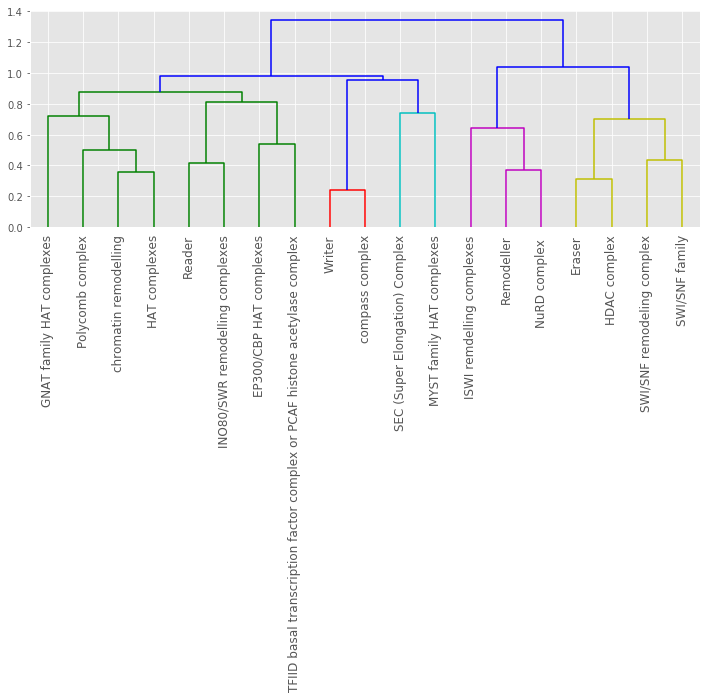

In [19]:
df_covariates = df_covariates.drop(['Testis-specific chromatin protein', 'REST corepressor',
       'ISWI chromatin remdelling','RNF20/40 complex','strelka_mutations', 'HPV_status'])

dftmp = df_covariates.drop(['HIV_status', 'clinic_histology', 'tumor_grade', 'age_at_diagnosis', 'epi_mutated']).apply(lambda x: x.map({'Mutated':True, 'Wild Type':False}))

dftmp.dtypes.head(2)

dftmp = dftmp.T

dftmp.head(2)

dftmp.apply(lambda x: x.all()).head(2)

pd.Series(dftmp.values.ravel()).unique()

fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)
feature_labels = plot_dengrogram(dftmp, ax)

df_covariates  = df_covariates.reindex(['HIV_status', 'clinic_histology', 'tumor_grade', 'epi_mutated'] + feature_labels)

feature_labels = df_covariates.index.tolist()
df_covariates = order_df(df_covariates, feature_labels, sample_labels)

df_covariates.head(3)

In [31]:
covariate_dict = get_legend_categories(df_covariates)

In [32]:
covariate_dict

{'HIV_status': ['Negative', 'Positive'],
 'clinic_histology': ['Adeno', 'Adenosquamous', 'Neuroendocrine', 'Squamous'],
 'tumor_grade': ['G1', 'G2', 'G3', 'unknown'],
 'epi_mutated': ['Mutated', 'Wild Type']}

In [33]:
df_covariates.shape

(23, 54)

In [34]:
dfmg.shape

(18022, 52)

CPU times: user 3.08 s, sys: 182 ms, total: 3.27 s
Wall time: 3.27 s


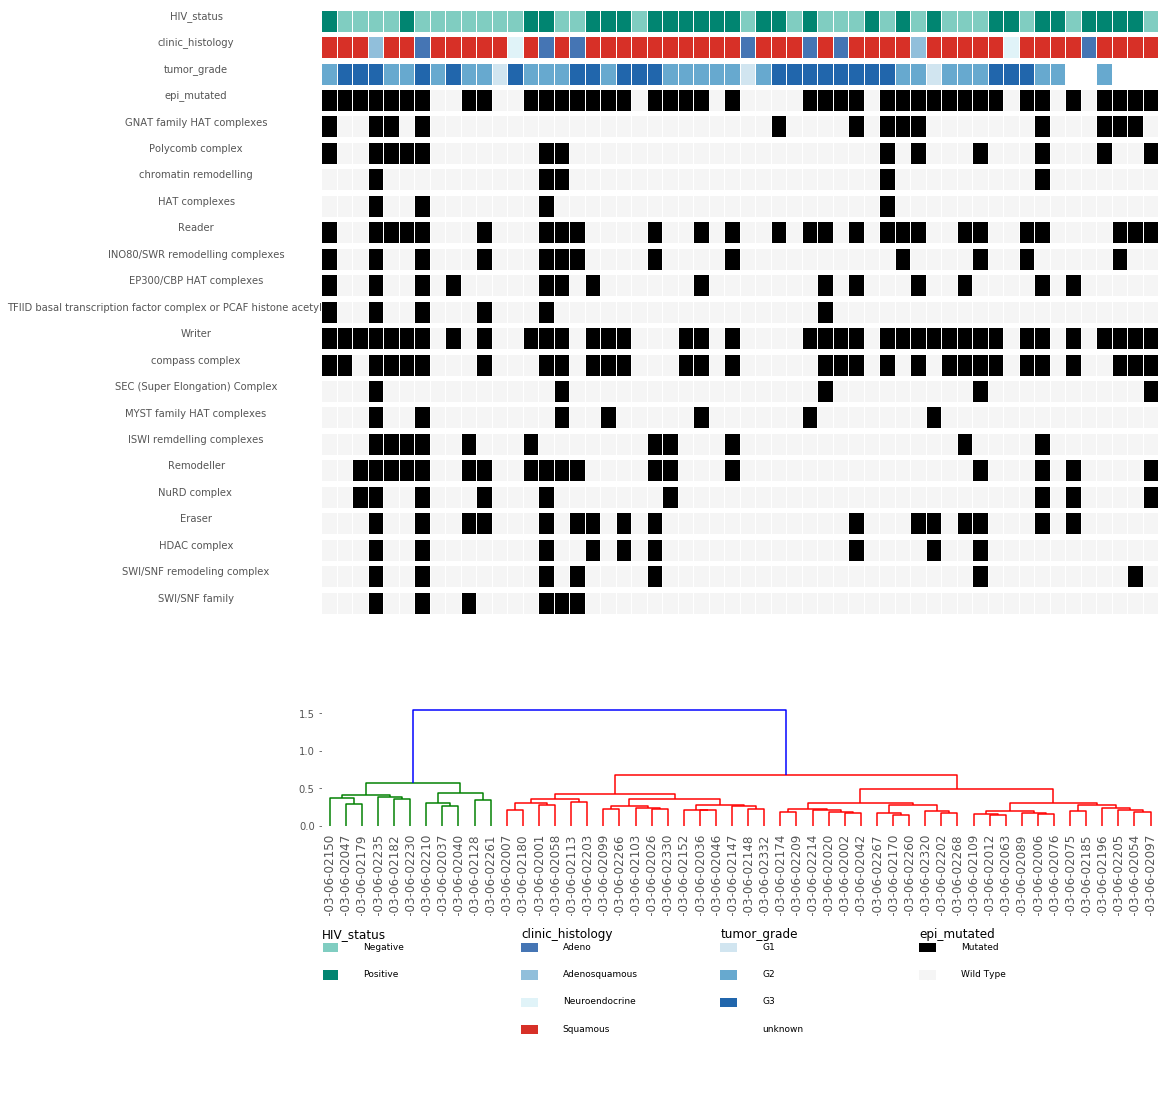

{'icoord': [[15.0, 15.0, 25.0, 25.0],
  [5.0, 5.0, 20.0, 20.0],
  [45.0, 45.0, 55.0, 55.0],
  [35.0, 35.0, 50.0, 50.0],
  [12.5, 12.5, 42.5, 42.5],
  [75.0, 75.0, 85.0, 85.0],
  [65.0, 65.0, 80.0, 80.0],
  [95.0, 95.0, 105.0, 105.0],
  [72.5, 72.5, 100.0, 100.0],
  [27.5, 27.5, 86.25, 86.25],
  [115.0, 115.0, 125.0, 125.0],
  [135.0, 135.0, 145.0, 145.0],
  [120.0, 120.0, 140.0, 140.0],
  [155.0, 155.0, 165.0, 165.0],
  [130.0, 130.0, 160.0, 160.0],
  [175.0, 175.0, 185.0, 185.0],
  [205.0, 205.0, 215.0, 215.0],
  [195.0, 195.0, 210.0, 210.0],
  [180.0, 180.0, 202.5, 202.5],
  [235.0, 235.0, 245.0, 245.0],
  [225.0, 225.0, 240.0, 240.0],
  [265.0, 265.0, 275.0, 275.0],
  [255.0, 255.0, 270.0, 270.0],
  [232.5, 232.5, 262.5, 262.5],
  [191.25, 191.25, 247.5, 247.5],
  [145.0, 145.0, 219.375, 219.375],
  [285.0, 285.0, 295.0, 295.0],
  [325.0, 325.0, 335.0, 335.0],
  [315.0, 315.0, 330.0, 330.0],
  [305.0, 305.0, 322.5, 322.5],
  [290.0, 290.0, 313.75, 313.75],
  [355.0, 355.0, 365.0, 36

In [40]:
plot_cluster_heatmap(dfmg, df_covariates)